# Using Physics-Based Loss to Better Generalize Model Training 
From modified Beer-Lambert Law, we know that 
$$
\Delta OD = <L_i(r)> \Delta \mu_(a,i)
$$
Where, $\Delta OD$ is the pulsation ratio(for a given wavelength) defined as $log(I_2)/log(I_1)$, i is the index of the tissue layer where pulsation occurs, $<L>$ corresponds to the source-detector distance (SDD) dependent **mean** photon pathlength within that layer. This can be further modified as 
$$
\Delta OD = <L_i(r)> \Delta c_(Hb) \times \epsilon(S)
$$
The corresponding loss term should thus be
$$
(\Delta OD - <L_i(r)> \Delta c_(Hb) \times \epsilon(S)) ^ 2
$$


In [54]:
from pathlib import Path
import json
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from model_trainer import (
    ModelTrainer,
    RandomSplit,
    CVSplit,
    SumLoss,
    TorchLossWrapper,
    DataLoaderGenerator3,
)
from inverse_modelling_tfo.model_training.loss_funcs import BLPathlengthLoss, TorchLossWithChangingWeight

from inverse_modelling_tfo.model_training.custom_models import (
    PerceptronBD,
    CNN2FC,
    FeatureResidualNetwork,
    CNN2FC2dInput,
    SplitChannelCNN,
)
from inverse_modelling_tfo.visualization import generate_model_error_and_prediction
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Pre-save data

In [56]:
file_name1 = 'I1_and_I2'
file_name2 = 'pulsation_ratio'

# Load data
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name1}.pkl"
data1 = pd.read_pickle(DATA_PATH)
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name2}.pkl"
data2 = pd.read_pickle(DATA_PATH)

# Load Configs
CONFIG_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name1}.json"
with open(CONFIG_PATH, "r") as f:
    config1 = json.load(f)
CONFIG_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name2}.json"
with open(CONFIG_PATH, "r") as f:
    config2 = json.load(f)
labels = config1["labels"]  # Should have the same labels
intensity = config1["features"]
pulsation_ratio = config2["features"]

data = pd.merge(data1, data2, on=labels, how="inner")

# Cleanup
data.dropna(inplace=True)

In [57]:
# Filter data so I don't have to wait for too long during training
# data = data[
#     (data["Maternal Wall Thickness"] >= 4.0)
#     & (data["Maternal Wall Thickness"] <= 20.0)
# ]
print("training with", len(data), "samples")

training with 33480 samples


In [58]:
data.columns

Index(['10_2.0_1', '15_2.0_1', '19_2.0_1', '24_2.0_1', '28_2.0_1', '33_2.0_1',
       '37_2.0_1', '41_2.0_1', '46_2.0_1', '50_2.0_1',
       ...
       'MAX_ACbyDC_WV1_77', 'MAX_ACbyDC_WV2_77', 'MAX_ACbyDC_WV1_81',
       'MAX_ACbyDC_WV2_81', 'MAX_ACbyDC_WV1_86', 'MAX_ACbyDC_WV2_86',
       'MAX_ACbyDC_WV1_90', 'MAX_ACbyDC_WV2_90', 'MAX_ACbyDC_WV1_94',
       'MAX_ACbyDC_WV2_94'],
      dtype='object', length=127)

# Combining Physics Based Terms

In [59]:
# Create the pathlength mean columns
pathlength_stats = Path(r'/home/rraiyan/simulations/tfo_sim/data/pathlength_stats/dan_iccps_pencil2.pkl')
pathlength_stats = pd.read_pickle(pathlength_stats)

l4_mean_column_names = list(filter(lambda x: 'L4 ppath_mean' in x, pathlength_stats.columns))
wv1_ppath = (pathlength_stats[pathlength_stats['Wave Int'] == 1])[['Maternal Wall Thickness'] + l4_mean_column_names]
wv2_ppath = (pathlength_stats[pathlength_stats['Wave Int'] == 2])[['Maternal Wall Thickness'] + l4_mean_column_names]
wv1_ppath.set_index(['Maternal Wall Thickness'], inplace=True)
wv2_ppath.set_index(['Maternal Wall Thickness'], inplace=True)
pathlength_stats.drop(columns=['Wave Int'], inplace=True)   # Don't need this column anymore

# Append the pathlength stats to the data
for column in wv1_ppath.columns:
    data[column + ' WV1'] = data['Maternal Wall Thickness'].map(wv1_ppath[column])
for column in wv2_ppath.columns:
    data[column + ' WV2'] = data['Maternal Wall Thickness'].map(wv2_ppath[column])

# Defining feature groups
wv1_pulsation_ratio = list(filter(lambda x: 'WV1' in x, pulsation_ratio))
wv2_pulsation_ratio = list(filter(lambda x: 'WV2' in x, pulsation_ratio))
wv1_intensity = list(filter(lambda x: '1.0' in x, intensity))
wv2_intensity = list(filter(lambda x: '2.0' in x, intensity))
wv1_ppath = [x + ' WV1' for x in l4_mean_column_names]  # Replace with the new column names
wv2_ppath = [x + ' WV2' for x in l4_mean_column_names]  # Replace with the new column names

# Pulsation Ratio copy (This will be left unscaled)
unscaled_pulsation_ratio_columns = [x + ' unscaled' for x in pulsation_ratio]
temp = data[pulsation_ratio]
temp.columns = unscaled_pulsation_ratio_columns
data = pd.concat([data, temp], axis=1)  # Avoids contiguity issues

# Calculate The BL-Based Term 

In [60]:
from inverse_modelling_tfo.tools.optical_properties import get_tissue_mu_a

def calculate_mua0_wv2(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 1"], row["Fetal Saturation"], wave_int=2)
    return mu_a

def calculate_mua1_wv2(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 2"], row["Fetal Saturation"], wave_int=2)
    return mu_a

def calculate_mua0_wv1(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 1"], row["Fetal Saturation"], wave_int=1)
    return mu_a

def calculate_mua1_wv1(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 2"], row["Fetal Saturation"], wave_int=1)
    return mu_a

data["Fetal Mua 0 WV2"] = data.apply(calculate_mua0_wv2, axis=1)
data["Fetal Mua 1 WV2"] = data.apply(calculate_mua1_wv2, axis=1)
data["Fetal Mua 0 WV1"] = data.apply(calculate_mua0_wv1, axis=1)
data["Fetal Mua 1 WV1"] = data.apply(calculate_mua1_wv1, axis=1)

data["Delta Mu WV2"] = data["Fetal Mua 1 WV2"] - data["Fetal Mua 0 WV2"]
data["Delta Mu WV1"] = data["Fetal Mua 1 WV1"] - data["Fetal Mua 0 WV1"]

# Generate the BL columns
# Create an empty dataframe, fillup with BLs, concat back into original, this way avoids data contiguity issues
bl_column_names = [f'{column}_BL WV1' for column in l4_mean_column_names] + [f'{column}_BL WV2' for column in l4_mean_column_names]
unscaled_bl_df = pd.DataFrame(columns=bl_column_names)
for wv1_column, wv2_column, column in zip(wv1_ppath, wv2_ppath, l4_mean_column_names):
    unscaled_bl_df[f'{column}_BL WV1'] = data[wv1_column] * (data['Fetal Mua 0 WV1'] - data['Fetal Mua 1 WV1'])
    unscaled_bl_df[f'{column}_BL WV2'] = data[wv2_column] * (data['Fetal Mua 0 WV2'] - data['Fetal Mua 1 WV2'])
data = pd.concat([data, unscaled_bl_df], axis=1)
# Get the indices
bl_column_indices = [data.columns.get_loc(column) for column in bl_column_names]

# Setup Training Objective

In [61]:
# Predict the mu_a as well as the pathlengths for each detector
# y_columns = ['Fetal Mua 0 WV1', 'Fetal Mua 1 WV1', 'Fetal Mua 0 WV2', 'Fetal Mua 1 WV2'] + wv1_ppath + wv2_ppath  # MuA + Partial pathlengths
# y_columns = ['Fetal Mua 0 WV1', 'Fetal Mua 1 WV1', 'Fetal Mua 0 WV2', 'Fetal Mua 1 WV2', 'Fetal Saturation'] + wv1_ppath + wv2_ppath  # MuA + Saturation + Partial pathlengths
y_columns = ['Fetal Mua 0 WV1', 'Fetal Mua 1 WV1', 'Fetal Mua 0 WV2', 'Fetal Mua 1 WV2', 'Fetal Saturation'] # MuA + Saturation
# y_columns = ["Delta Mu WV1", "Delta Mu WV2"] + wv1_ppath + wv2_ppath  # delta MuA + Partial pathlengths

# x_columns = features  # What to use as input
# x_columns = intensity  # What to use as input
x_columns = pulsation_ratio

## Normalizing Features
x_columns will be the input features and y_columns are the target

In [62]:
## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]
# x_columns = list(filter(lambda X: 'alpha' in X, data.columns))
## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
## Scheme 1 - Per detector normalization
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

## Model Configuration

In [63]:
print("In Features :", x_columns)  
print("In Features Len:", len(x_columns))
print("Out Features:", y_columns)
print("Out Features Len:", len(y_columns))
print("Extra Features:", unscaled_pulsation_ratio_columns)
print("Extra Features Len:", len(unscaled_pulsation_ratio_columns))

In Features : ['MAX_ACbyDC_WV1_10', 'MAX_ACbyDC_WV1_15', 'MAX_ACbyDC_WV1_19', 'MAX_ACbyDC_WV1_24', 'MAX_ACbyDC_WV1_28', 'MAX_ACbyDC_WV1_33', 'MAX_ACbyDC_WV1_37', 'MAX_ACbyDC_WV1_41', 'MAX_ACbyDC_WV1_46', 'MAX_ACbyDC_WV1_50', 'MAX_ACbyDC_WV1_55', 'MAX_ACbyDC_WV1_59', 'MAX_ACbyDC_WV1_64', 'MAX_ACbyDC_WV1_68', 'MAX_ACbyDC_WV1_72', 'MAX_ACbyDC_WV1_77', 'MAX_ACbyDC_WV1_81', 'MAX_ACbyDC_WV1_86', 'MAX_ACbyDC_WV1_90', 'MAX_ACbyDC_WV1_94', 'MAX_ACbyDC_WV2_10', 'MAX_ACbyDC_WV2_15', 'MAX_ACbyDC_WV2_19', 'MAX_ACbyDC_WV2_24', 'MAX_ACbyDC_WV2_28', 'MAX_ACbyDC_WV2_33', 'MAX_ACbyDC_WV2_37', 'MAX_ACbyDC_WV2_41', 'MAX_ACbyDC_WV2_46', 'MAX_ACbyDC_WV2_50', 'MAX_ACbyDC_WV2_55', 'MAX_ACbyDC_WV2_59', 'MAX_ACbyDC_WV2_64', 'MAX_ACbyDC_WV2_68', 'MAX_ACbyDC_WV2_72', 'MAX_ACbyDC_WV2_77', 'MAX_ACbyDC_WV2_81', 'MAX_ACbyDC_WV2_86', 'MAX_ACbyDC_WV2_90', 'MAX_ACbyDC_WV2_94']
In Features Len: 40
Out Features: ['Fetal Mua 0 WV1', 'Fetal Mua 1 WV1', 'Fetal Mua 0 WV2', 'Fetal Mua 1 WV2', 'Fetal Saturation']
Out Features L

# Defining A Custom Physics Based Loss

In [64]:
from model_trainer import LossFunction
from sklearn.preprocessing import StandardScaler


def calculate_eps_tensor(saturation, wave_int):
    mu_a = get_tissue_mu_a(0.1, 1.0, saturation, wave_int)
    return mu_a


class EquateDeltaCLoss(LossFunction):
    def __init__(
        self,
        mu1_wv1_index: int,
        mu1_wv2_index: int,
        mu2_wv1_index: int,
        mu2_wv2_index: int,
        saturation_index: int,
        model_output_scaler: StandardScaler,
        device: torch.device = torch.device("cuda"),
        name: str = "delC",
    ):
        super().__init__(name=name)
        self.mu1_wv1_index = mu1_wv1_index
        self.mu1_wv2_index = mu1_wv2_index
        self.mu2_wv1_index = mu2_wv1_index
        self.mu2_wv2_index = mu2_wv2_index
        self.saturation_index = saturation_index
        scaler_mean = model_output_scaler.mean_
        scaler_scale = model_output_scaler.scale_
        scaler_mean = torch.tensor(scaler_mean, device=device)
        scaler_scale = torch.tensor(scaler_scale, device=device)
        self.mu1_wv1_mean = scaler_mean[mu1_wv1_index]
        self.mu1_wv1_scale = scaler_scale[mu1_wv1_index]
        self.mu1_wv2_mean = scaler_mean[mu1_wv2_index]
        self.mu1_wv2_scale = scaler_scale[mu1_wv2_index]
        self.mu2_wv1_mean = scaler_mean[mu2_wv1_index]
        self.mu2_wv1_scale = scaler_scale[mu2_wv1_index]
        self.mu2_wv2_mean = scaler_mean[mu2_wv2_index]
        self.mu2_wv2_scale = scaler_scale[mu2_wv2_index]
        self.saturation_mean = scaler_mean[saturation_index]
        self.saturation_scale = scaler_scale[saturation_index]
    
    def __call__(self, model_output, dataloader_data, trainer_mode: str):
        # Formula \Delta \mu_1 * \eps_1 - \Delta \mu_2 * \eps_2 = 0
        mu1_wv1 = model_output[:, self.mu1_wv1_index] * self.mu1_wv1_scale + self.mu1_wv1_mean
        mu1_wv2 = model_output[:, self.mu1_wv2_index] * self.mu1_wv2_scale + self.mu1_wv2_mean
        mu2_wv1 = model_output[:, self.mu2_wv1_index] * self.mu2_wv1_scale + self.mu2_wv1_mean
        mu2_wv2 = model_output[:, self.mu2_wv2_index] * self.mu2_wv2_scale + self.mu2_wv2_mean
        saturation = model_output[:, self.saturation_index] * self.saturation_scale + self.saturation_mean
        delta_mu_wv1 = mu1_wv1 - mu2_wv1
        delta_mu_wv2 = mu1_wv2 - mu2_wv2
        eps_wv1 = calculate_eps_tensor(saturation, 1)
        eps_wv2 = calculate_eps_tensor(saturation, 2)
        delta_c = delta_mu_wv1 * eps_wv1 - delta_mu_wv2 * eps_wv2
        # Update Tracker
        loss = torch.square(delta_c).mean()
        self.loss_tracker_step_update(loss.item(), trainer_mode)
        return loss

    def __str__(self):
        return f"Equating Delta C For Both Wavelengths"

# Training Configs

In [75]:
from model_trainer import HoldOneOut

IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)
set_seed(42)
data_loader_params = {"shuffle": True}  # Shuffles the data in between epochs - thought to be a good idea
dataloader_gen = DataLoaderGenerator3(
    data, x_columns, y_columns, unscaled_pulsation_ratio_columns, 512, data_loader_params
)

# loss_delay = 5
# loss_endw = 10.0
# loss_epoch = 20
criterion0 = TorchLossWrapper(nn.MSELoss(), [0, 1, 2, 3], name="label_mua")
criterion1 = TorchLossWrapper(nn.MSELoss(), [4], name="label_saturation")
# criterion2 = TorchLossWrapper(nn.MSELoss(), list(range(5, len(x_columns))), name="label_ppath")
# criterion3 = BLPathlengthLoss(0, 1, list(range(5, 25)), list(range(20)), y_scaler, name="physics_loss_wv1")
# criterion4 = BLPathlengthLoss(2, 3, list(range(25, 45)), list(range(20, 40)), y_scaler, name="physics_loss_wv2")
criterion5 = EquateDeltaCLoss(0, 1, 2, 3, 4, y_scaler, name="delta_c")
criterion = SumLoss(
    [criterion0, criterion1, criterion5], [1.0, 1.0, 1e11]
)
# criterion = SumLoss([criterion0, criterion1], [2.0, 1.0])
# criterion = SumLossBalanced([criterion0, criterion1, criterion2, criterion3], 10, 10)

# model = PerceptronBD([IN_FEATURES, 80, 50, OUT_FEATURES])  # Current Best
model = PerceptronBD([IN_FEATURES, 40, 20, 10, OUT_FEATURES]) 
# model = PerceptronBD([IN_FEATURES, 40, 20, 10, 10, 20, OUT_FEATURES])
# model = SplitChannelCNN(IN_FEATURES, 2, [4, 8, 12], [7, 5, 3], [10, 20, OUT_FEATURES])

# validation_method = RandomSplit(0.8)
all_depth = data["Maternal Wall Thickness"].unique()
all_depth.sort()
validation_method = HoldOneOut("Maternal Wall Thickness", all_depth[3])

trainer = ModelTrainer(model, dataloader_gen, validation_method, criterion)

## Custom Training

In [76]:
# trainer.set_batch_size(32)
trainer.set_batch_size(32)
trainer.set_optimizer(SGD, {'lr': 6e-4, 'momentum': 0.89, 'weight_decay': 1e-4})
trainer.run(2)

Unweighted Training Label loss(MSE) 1.011715075694326
Unweighted Validation Label loss(MSE) 1.01050982931081


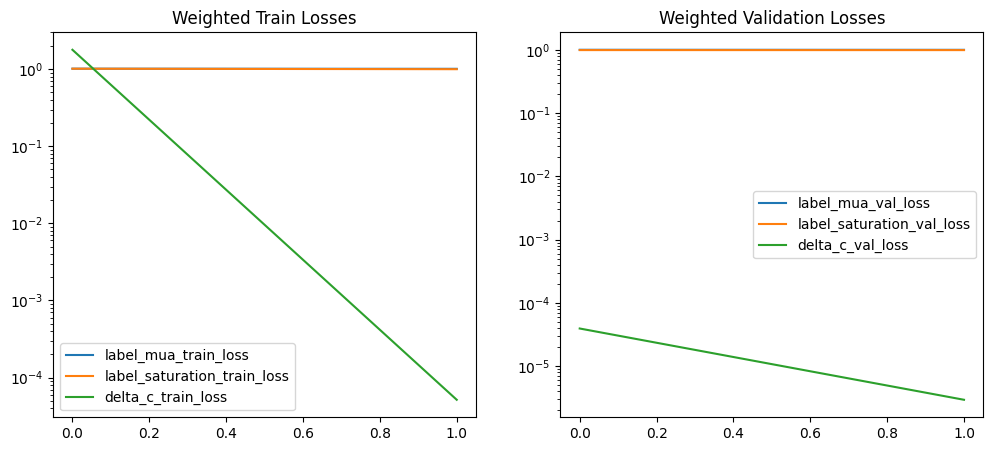

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()
for index, loss_sets in enumerate([criterion.train_losses, criterion.val_losses]):
    plt.sca(axes[index])
    for loss in loss_sets:
        plt.plot(criterion.loss_tracker.epoch_losses[loss], label=loss)
    plt.legend()
    plt.yscale('log')
    plt.title("Weighted Train Losses" if index == 0 else "Weighted Validation Losses")

print("Unweighted Training Label loss(MSE)", criterion0.loss_tracker.epoch_losses['label_mua_train_loss'][-1])
print("Unweighted Validation Label loss(MSE)", criterion0.loss_tracker.epoch_losses['label_mua_val_loss'][-1])
fig_loss = plt.gcf()

In [78]:
# Increase batch_size for faster visuals generation - (does not affect training!)
prev_batch_size = dataloader_gen.batch_size
trainer.set_batch_size(4096)
# Does MAE by default. Provide a value to error_func to change it
train_error, train_pred = generate_model_error_and_prediction(trainer.model, trainer.train_loader, y_columns, y_scaler)
val_error, val_pred = generate_model_error_and_prediction(trainer.model, trainer.validation_loader, y_columns, y_scaler)
trainer.set_batch_size(prev_batch_size)

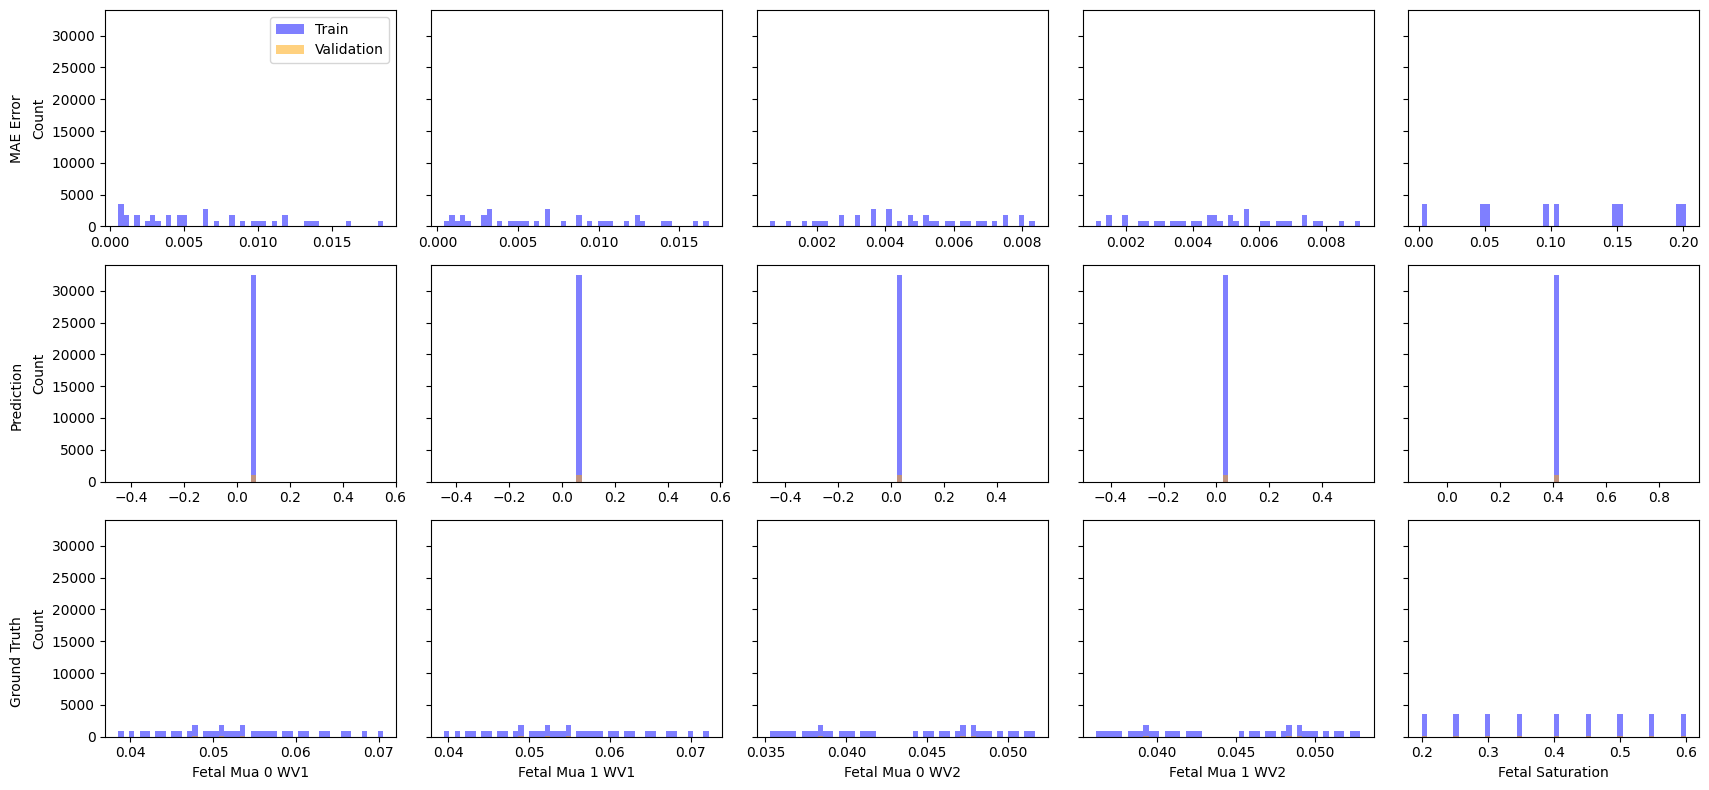

In [79]:
PLOT_FIRST_N = 7
y_columns_to_plot = y_columns[:PLOT_FIRST_N]
fig_dist, axes = plt.subplots(3, len(y_columns_to_plot), squeeze=True, figsize=(17, 8), sharey=True)
BIN_COUNT = 50

train_data_truth = y_scaler.inverse_transform(trainer.train_loader.dataset[:][1].cpu())
val_data_truth = y_scaler.inverse_transform(trainer.validation_loader.dataset[:][1].cpu())

for i in range(len(y_columns_to_plot)):
    # Plot Errors
    ax = axes[0, i]
    plt.sca(ax)
    column_name = train_error.columns[i]
    plt.hist(train_error[column_name], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_error[column_name], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    
    # Plot Predictions
    ax = axes[1, i]
    plt.sca(ax)
    column_name = train_pred.columns[i]
    plt.hist(train_pred[column_name], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_pred[column_name], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    
    # Plot Ground Truth
    ax = axes[2, i]
    plt.sca(ax)
    plt.hist(train_data_truth[:, i], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_data_truth[:, i], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    # X Label for the bottommost row
    plt.xlabel(y_columns[i])
    
# Add text to the left of each row of plots
for i, label in enumerate(['MAE Error', 'Prediction', 'Ground Truth']):
    fig_dist.text(0, (2.5-i)/3, label, ha='center', va='center', rotation='vertical')

# Y Labels
for i in range(axes.shape[0]):
    axes[i, 0].set_ylabel('Count')

# Add labels to top-left subplot
axes[0, 0].legend()


plt.tight_layout()
plt.show()

In [80]:
print("Unnormalized Errors", str(train_error.iloc[:, :4].describe()) + '\n\n' + str(val_error.iloc[:, :4].describe())) 

Unnormalized Errors        Fetal Mua 0 WV1 Error  Fetal Mua 1 WV1 Error  Fetal Mua 0 WV2 Error  \
count           32400.000000           32400.000000           32400.000000   
mean                0.006642               0.006930               0.004717   
std                 0.004808               0.004674               0.002051   
min                 0.000557               0.000419               0.000633   
25%                 0.002746               0.003019               0.003186   
50%                 0.005753               0.006436               0.004707   
75%                 0.010014               0.010531               0.006357   
max                 0.018471               0.016836               0.008366   

       Fetal Mua 1 WV2 Error  
count           32400.000000  
mean                0.004838  
std                 0.002075  
min                 0.001088  
25%                 0.003254  
50%                 0.004764  
75%                 0.006311  
max                 0.009033 

In [81]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       1,640
│    └─BatchNorm1d: 2-2                  80
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       820
│    └─BatchNorm1d: 2-5                  40
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       210
│    └─BatchNorm1d: 2-8                  20
│    └─ReLU: 2-9                         --
│    └─Linear: 2-10                      55
│    └─Flatten: 2-11                     --
Total params: 2,865
Trainable params: 2,865
Non-trainable params: 0

In [82]:
# model_name = 'no_physics_loss_pr_to_mua'
# import joblib
# # Save Model
# torch.save(model.state_dict(), rf'../../models/{model_name}.pth')
# # Save the Scalers for Later Use
# joblib.dump(x_scaler, rf'../../models/{model_name}_xscaler')
# joblib.dump(y_scaler, rf'../../models/{model_name}_yscaler') 

In [83]:
# # Load Model Code
# model = PerceptronReLU([20, 10, 4, 2, 1])
# model.load_state_dict(torch.load(r'../models/fsat_delta_5det_v1'))
# model = model.cuda()
# x_scaler = joblib.load(rf'../models/{model_name}_xscaler')
# y_scaler = joblib.load(rf'../models/{model_name}_yscaler')

In [84]:
# from mdreport import MarkdownReport
# # Generate report

# report = MarkdownReport(Path('results'), 'report19', 'Returning Back to Hold-One Out Validation')
# report.add_text_report("Comment", "Same as report 18, but this time we drop the wavelength BL loss and only keep this delta C loss.")
# report.add_text_report("Comment", "This generalizes slightly better but still the generalization sucks. The training loss is pretty low though. ")
# report.add_code_report("Model Used", str(torchinfo.summary(trainer.model)))
# report.add_code_report("Unnormalized Errors", str(train_error.iloc[:, :4].describe()) + '\n\n' + str(val_error.iloc[:, :4].describe())) 
# report.add_text_report("Loss", f"""Mua Label Loss(training): {criterion0.loss_tracker.epoch_losses['label_mua_train_loss'][-1]},
#                        Mua Label loss(validation): {criterion0.loss_tracker.epoch_losses['label_mua_val_loss'][-1]}""")
# report.add_code_report("Model Trainer Params", str(trainer))
# report.add_image_report("Loss Curves", fig_loss)
# report.add_image_report("Prediction & Error Distribution", fig_dist)
# report.save_report()